In [1]:
# Step 1.1: Setup and Path Configuration
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
DATA_ROOT = '/content/drive/MyDrive/Project 2 Data/Data'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
VALID_DIR = os.path.join(DATA_ROOT, 'valid')
TEST_DIR  = os.path.join(DATA_ROOT, 'test')

# Image + batchig
TARGET_SIZE = (500, 500)
BATCH_SIZE = 32
SEED = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Step 1.2: Verify Folder Structure and Image Counts

# Count the number of images in each cass directory for train/validation/test
def count_images(folder):
    counts = {}
    for cls in sorted(os.listdir(folder)):
        cls_path = os.path.join(folder, cls)
        if os.path.isdir(cls_path):
            counts[cls] = sum(
                os.path.isfile(os.path.join(cls_path, f)) for f in os.listdir(cls_path)
            )
    return counts

# Display counts for train, valdation, and test split
for name, path in [('train', TRAIN_DIR), ('valid', VALID_DIR), ('test', TEST_DIR)]:
    print(f"\n[{name}] {path}")
    c = count_images(path)
    for k, v in c.items():
        print(f"  {k:12s}: {v}")
    print(f"  total: {sum(c.values())}")



[train] /content/drive/MyDrive/Project 2 Data/Data/train
  crack       : 676
  missing-head: 661
  paint-off   : 605
  total: 1942

[valid] /content/drive/MyDrive/Project 2 Data/Data/valid
  crack       : 175
  missing-head: 169
  paint-off   : 87
  total: 431

[test] /content/drive/MyDrive/Project 2 Data/Data/test
  crack       : 211
  missing-head: 200
  paint-off   : 128
  total: 539


In [3]:
# Step 1.3: Create ImageDataGenerators for Train, Validation, and Test Sets

# Training genenator with light augmentation and noemalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=12,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/testing generator with only normalization
eval_datagen = ImageDataGenerator(rescale=1./255)

# Load training images into batches with augmentations
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

# Load validation images without augmentation
valid_gen = eval_datagen.flow_from_directory(
    VALID_DIR,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Load test images without augmentation
test_gen = eval_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Dsiplays mapping
print("Class indices:", train_gen.class_indices)


Found 1942 images belonging to 3 classes.
Found 431 images belonging to 3 classes.
Found 539 images belonging to 3 classes.
Class indices: {'crack': 0, 'missing-head': 1, 'paint-off': 2}


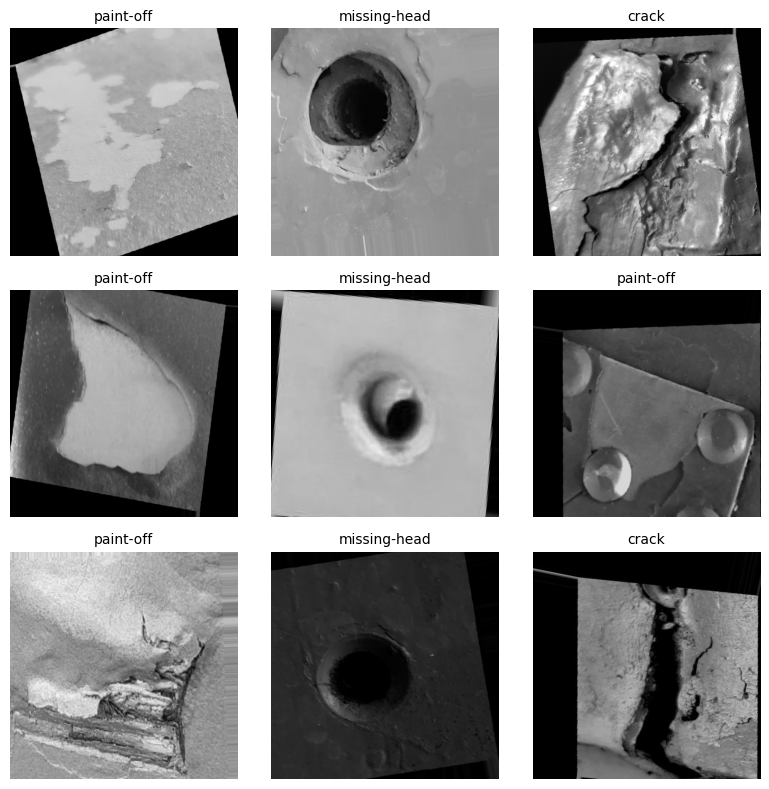

In [4]:
# Step 1.4: Visualize Sample Images from Training Set

# Get one batch of images and labels
images, labels = next(train_gen)

# Limit display coumt to at most 9 images
n = min(9, images.shape[0])

# Map numeric labels back to clas names
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

plt.figure(figsize=(8, 8))
for i in range(n):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(idx_to_class[np.argmax(labels[i])], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
# Step 2.1: Imports and Common Settings
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

INPUT_SHAPE = (500, 500, 3)   # required shape
N_CLASSES = 3                  # crack, missinghead, paintoff


In [6]:
# Step 2.2: Model A: Shallow Baseline CNN
def build_model_a(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    model = models.Sequential([
        # Block 1 with 32 filters
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Block 2 with 64 filters
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Classifier head
        layers.Flatten(), # Flatten to 1D vectpor
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax') # Ouput layer
    ])

    # Compile model with Adam optimizer and categorical cross-entropy loss
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_a = build_model_a()
model_a.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 500, 500, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 250, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000000)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   128,000,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,019,907 (488.36 MB)

 Trainable params: 128,019,907 (488.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Step 2.3: Model B: Deeper CNN
def build_model_b(input_shape=INPUT_SHAPE, n_classes=N_CLASSES):
    model = models.Sequential([
        # Block 1 - Two layers with 32 filters
        layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Block 2 - Two layers with 64 filters
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.Conv2D(64, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Block 3 - Two layers with 128 filters
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.Conv2D(128, (3,3), padding='same', activation='relu'),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Classifier head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_b = build_model_b()
model_b.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 500, 500, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 500, 500, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 250, 250, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 250, 250, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 250, 250, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 125, 125, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │   125,960,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,248,227 (481.60 MB)

 Trainable params: 126,248,227 (481.60 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Step 3.1: Base Data Setup
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.activations import relu, elu
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

INPUT_SHAPE = (500, 500, 3)
N_CLASSES = 3

Policy: <DTypePolicy "mixed_float16">


In [9]:
# Step 3.2: Defining a function that builds CNNs
def build_cnn(activation='relu', dense_act='relu', filters=[32,64,128]):
    model = models.Sequential()

    # Convolutional blocks
    for f in filters:
        model.add(layers.Conv2D(f, (3,3), padding='same', activation=activation, input_shape=INPUT_SHAPE))
        model.add(layers.MaxPooling2D((2,2)))

    # Flatten + Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=dense_act))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(N_CLASSES, activation='softmax'))

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [10]:
# Step 3.3: CNN builder

from tensorflow.keras import layers, models, optimizers

INPUT_SHAPE = (500, 500, 3)
N_CLASSES   = 3

def build_cnn(conv_activation='relu', dense_activation='relu', filters=(32, 64, 128), lr=1e-3):
    inputs = layers.Input(shape=INPUT_SHAPE)  # Define model input tensor
    x = inputs

    for f in filters:
        # Use_bias=False and BatchNorm is a common, efficient combo
        x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x)  # Conv without bias
        x = layers.BatchNormalization()(x)  # Normalize activations for stability

        # Apply activation
        if conv_activation.lower() == 'leakyrelu':
            x = layers.LeakyReLU(alpha=0.1)(x)
        else:
            x = layers.Activation(conv_activation)(x)

        x = layers.MaxPooling2D()(x)

    # GAP instead of Flatten keeps params small and speeds up training
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation=dense_activation)(x)
    x = layers.Dropout(0.4)(x)

    # Keep float32 on the final layer (helps when using mixed precision)
    outputs = layers.Dense(N_CLASSES, activation='softmax', dtype='float32')(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
# Step 3.4: Hyperparameter Sweep

configs = [
    ('relu',      'relu', (32,64,128)),
    ('leakyrelu', 'relu', (32,64,128)),
    ('relu',      'elu',  (64,128,256)),
]

results = []  # Stor results for comparioson

for conv_act, dense_act, fltrs in configs:
    print(f"\nTesting conv_act={conv_act}, dense_act={dense_act}, filters={fltrs}")

    # Build model wih selected hyperparameters
    model = build_cnn(conv_activation=conv_act,
                      dense_activation=dense_act,
                      filters=fltrs)
    # Train to compare high-level performance
    history = model.fit(train_gen,
                        validation_data=valid_gen,
                        epochs=3,
                        verbose=1)

    # Extract validation metrics from last epoch
    val_acc  = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    # Save configuartion and performance
    results.append((conv_act, dense_act, fltrs, val_acc, val_loss))
    print(f" -> val_acc={val_acc:.3f} | val_loss={val_loss:.3f}")


print("\n=== Summary of Results ===")
for r in results:
    print(f"Conv={r[0]}, Dense={r[1]}, Filters={r[2]}  → Val_Acc={r[3]:.3f}, Val_Loss={r[4]:.3f}")



Testing conv_act=relu, dense_act=relu, filters=(32, 64, 128)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 839s 13s/step - accuracy: 0.4050 - loss: 1.1267 - val_accuracy: 0.3921 - val_loss: 1.1598
Epoch 2/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4942 - loss: 1.0298 - val_accuracy: 0.3921 - val_loss: 1.1841
Epoch 3/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4418 - loss: 1.0622 - val_accuracy: 0.4084 - val_loss: 1.1845
 -> val_acc=0.408 | val_loss=1.184

Testing conv_act=leakyrelu, dense_act=relu, filters=(32, 64, 128)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4172 - loss: 1.1782 - val_accuracy: 0.3921 - val_loss: 1.1575
Epoch 2/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.4492 - loss: 1.0529 - val_accuracy: 0.3921 - val_loss: 1.1520
Epoch 3/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.4511 - loss: 1.0469 - val_accuracy: 0.4037 - val_loss: 1.1393
 -> val_acc=0.404 | val_loss=1.139

Testing conv_act=relu, dense_act=elu, filters=(64, 128, 256)
Epoch 1/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 796s 7s/step - accuracy: 0.3881 - loss: 1.3011 - val_accuracy: 0.3921 - val_loss: 1.1987
Epoch 2/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.4066 - loss: 1.1685 - val_accuracy: 0.4084 - val_loss: 1.0954
Epoch 3/3
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4430 - loss: 1.0974 - val_accuracy: 0.3921 - val_loss: 1.1698
 -> val_acc=0.392 | val_loss=1.170

=== Summary of Results ===
Conv=relu, Dense=relu, Filters=(32, 64, 128)  → Val_Acc=0.408, Val_Loss=1.184
Conv=l

In [13]:
# Step 4.1: Pick your best config

# Build new model using best params from previous step
best_model = build_cnn(
    conv_activation='relu',
    dense_activation='elu',
    filters=(64,128,256)
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Path to save the best model
ckpt_path = "best_model.keras"
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

# Traing the best model for up to 30 epochs
history = best_model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=30,
    verbose=1,
    callbacks=callbacks
)


Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3955 - loss: 1.2524 - val_accuracy: 0.3968 - val_loss: 1.1693
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4069 - loss: 1.1171 - val_accuracy: 0.3898 - val_loss: 1.0955
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4484 - loss: 1.1077 - val_accuracy: 0.2947 - val_loss: 1.2286
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.4551 - loss: 1.1014 - val_accuracy: 0.2970 - val_loss: 1.2432
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4369 - loss: 1.0888 - val_accuracy: 0.3782 - val_loss: 1.1047
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4297 - loss: 1.0918 - val_accuracy: 0.3828 - val_loss: 1.1164
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4775 - loss: 1.0568 - val_accuracy: 0.3666 - val_loss: 1.1126


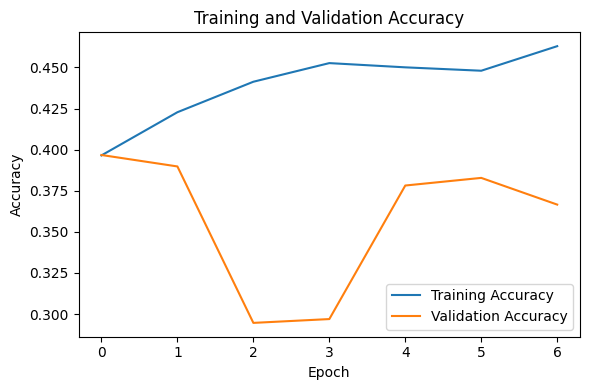

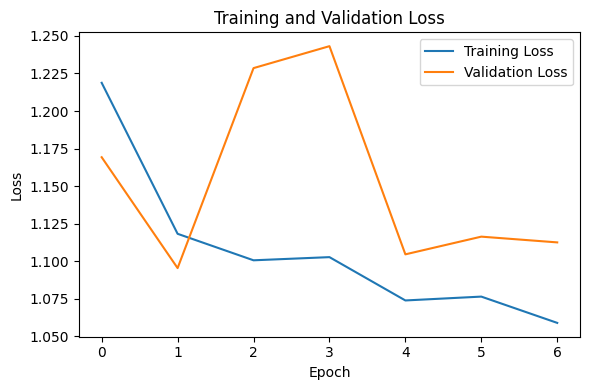

In [14]:
# Step 4.2: Plot Training vs Validation
import matplotlib.pyplot as plt

def plot_history(h):
    acc = h.history.get("accuracy", [])
    val_acc = h.history.get("val_accuracy", [])
    loss = h.history.get("loss", [])
    val_loss = h.history.get("val_loss", [])

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history)


In [15]:
# Evaluate trained model and print validation accuratcy and loss
val_loss, val_acc = best_model.evaluate(valid_gen, verbose=0)
print(f"Validation — Accuracy: {val_acc:.4f}  |  Loss: {val_loss:.4f}")


Validation — Accuracy: 0.3898  |  Loss: 1.0955
